In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
tweets_df = pd.read_csv("./datasets/$OCEAN tweets dataset.csv")
prices_df = pd.read_csv("./datasets/OCEAN token price dataset.csv")
sentiment_df = pd.read_csv("./derived_datasets/twitter-roberta-base-sentiment.csv")

In [23]:
# prepping data
prices_df["date_dt"] = pd.to_datetime(prices_df["Date"])
tweets_df["date_dt"] = pd.to_datetime(tweets_df["date"])
tweets_prices_df = tweets_df.merge(prices_df, on="date_dt")
tweets_df["has_ocean_cashtag"] = tweets_df["tweet"].apply(lambda t: "$OCEAN" in t)
daily_tweets_df = tweets_df.query("has_ocean_cashtag").groupby("date_dt").agg({"has_ocean_cashtag": ["sum"],
                                                                               "likes_count": ["mean", "sum", "median", "max"],
                                                                               "retweets_count": ["mean", "sum", "median", "max"],
                                                                               "user_id": [pd.Series.nunique]})

In [24]:
# merging data
daily_tweets_df.columns = ['_'.join(col).strip() for col in daily_tweets_df.columns.values]
prices_daily_tweets_df = prices_df.merge(daily_tweets_df.reset_index(), on="date_dt")

In [25]:
# here we can see that the total tweets with the hashtag, the total likes, the sum of the retweets, and the unique user ids
# are all highly correlated. The metrics that are not include mean and median likes, mean and median retweets, and the max likes.
prices_daily_tweets_df.corr()["Close"]

/var/folders/78/16lmgb053h9gw2_n1k5r5hxr0000gn/T/ipykernel_18143/3929561294.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prices_daily_tweets_df.corr()["Close"]


Open                     0.992599
High                     0.996588
Low                      0.996257
Close                    1.000000
Adj Close                1.000000
Volume                   0.586595
has_ocean_cashtag_sum    0.478844
likes_count_mean         0.303864
likes_count_sum          0.575971
likes_count_median       0.097382
likes_count_max          0.307659
retweets_count_mean      0.205747
retweets_count_sum       0.480441
retweets_count_median    0.083475
retweets_count_max       0.262955
user_id_nunique          0.542722
Name: Close, dtype: float64

In [27]:
# we take the most promising of all the metrics and find they are all highly correlated with each other
# this makes sense because total tweets be associated with likes and retweets
prices_daily_tweets_df[["likes_count_sum", "retweets_count_sum", "user_id_nunique", "Close"]].corr()

,likes_count_sum,retweets_count_sum,user_id_nunique,Close
likes_count_sum,1.000000,0.878021,0.864697,0.575971
retweets_count_sum,0.878021,1.000000,0.758622,0.480441
user_id_nunique,0.864697,0.758622,1.000000,0.542722
Close,0.575971,0.480441,0.542722,1.000000


In [38]:
for var in ["likes_count_sum", "retweets_count_sum", "user_id_nunique"]:
    prices_daily_tweets_df[f"log_{var}"] = np.log(prices_daily_tweets_df[var] + 0.1)
prices_daily_tweets_df[["log_likes_count_sum", "log_retweets_count_sum", "log_user_id_nunique", "Close"]].corr()

,log_likes_count_sum,log_retweets_count_sum,log_user_id_nunique,Close
log_likes_count_sum,1.000000,0.945786,0.899480,0.486914
log_retweets_count_sum,0.945786,1.000000,0.843976,0.438994
log_user_id_nunique,0.899480,0.843976,1.000000,0.454642
Close,0.486914,0.438994,0.454642,1.000000


In [28]:
# here we get some derived metrics to see how much the price moved during a day
prices_daily_tweets_df["open_minus_close"] = (prices_daily_tweets_df["Open"] - prices_daily_tweets_df["Close"]) 
prices_daily_tweets_df["open_minus_close_pct"] = (prices_daily_tweets_df["Open"] - prices_daily_tweets_df["Close"]) / prices_daily_tweets_df["Open"] * 100

In [29]:
# we see that price moves are not associated with any of our tweets metrics
# I would have liked to see that the influential tweets value (likes_count_max, retweets_count_max) was associated with the change in price.
prices_daily_tweets_df[list(daily_tweets_df.columns) + ["Close", "open_minus_close", "open_minus_close_pct"]].corr()[["Close", "open_minus_close", "open_minus_close_pct"]]

,Close,open_minus_close,open_minus_close_pct
has_ocean_cashtag_sum,0.478844,-0.193671,-0.171073
likes_count_mean,0.303864,-0.105915,-0.116865
likes_count_sum,0.575971,-0.243326,-0.186745
likes_count_median,0.097382,-0.068189,-0.107381
likes_count_max,0.307659,-0.094927,-0.079867
retweets_count_mean,0.205747,-0.084250,-0.103016
retweets_count_sum,0.480441,-0.182997,-0.155902
retweets_count_median,0.083475,-0.045017,-0.053454
retweets_count_max,0.262955,-0.096711,-0.080762
user_id_nunique,0.542722,-0.179979,-0.150346


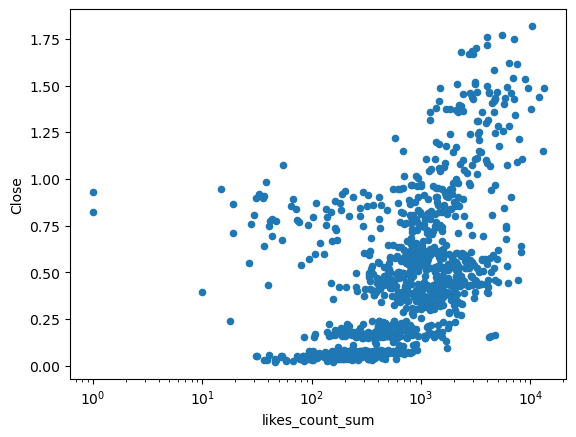

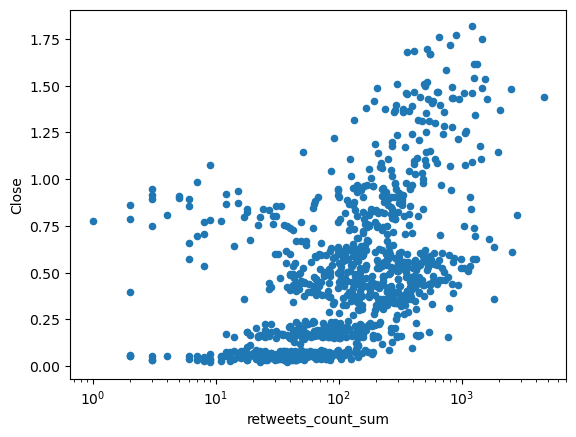

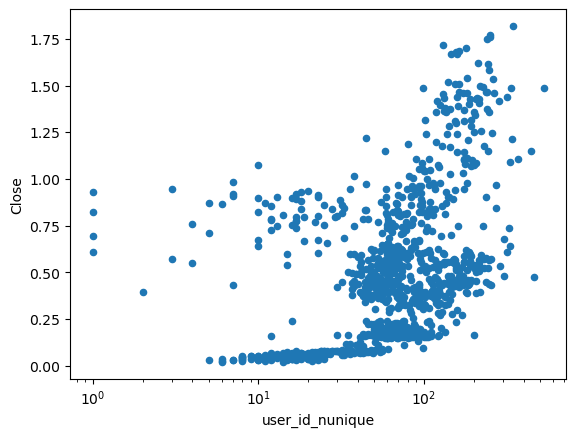

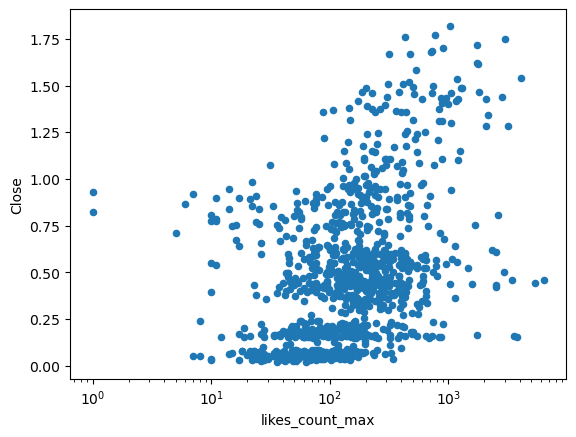

In [86]:
# here we can see that the likes log of these likes are fairly linearly related, although we 
# actually see another relationship in the middle of hese plots. I am not sure what this is
# but it is not related to a particular time period.

_ = prices_daily_tweets_df.plot(x="likes_count_sum", y="Close", kind="scatter")
plt.xscale("log")
_ = prices_daily_tweets_df.plot(x="retweets_count_sum", y="Close", kind="scatter")
plt.xscale("log")
_ = prices_daily_tweets_df.plot(x="user_id_nunique", y="Close", kind="scatter")
plt.xscale("log")
_ = prices_daily_tweets_df.plot(x="likes_count_max", y="Close", kind="scatter")
plt.xscale("log")

<Axes: >

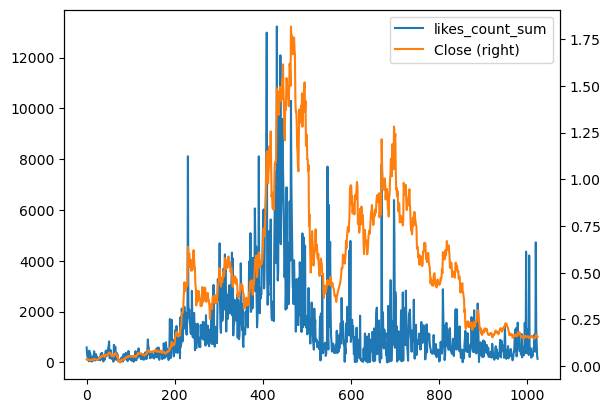

In [90]:
# It's interesting to see the time series here to see that the relationship breaks down a bit over time, where
# there's a pump in likes but no corresponding pump in price.

fig, ax = plt.subplots() 
prices_daily_tweets_df.plot(y=["likes_count_sum"], ax=ax)
prices_daily_tweets_df.plot(y=["Close"], ax=ax, secondary_y=True)

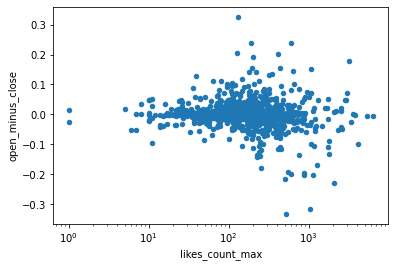

In [95]:
# here we verify that the max likes on a tweet is not associated with price moves.
_ = prices_daily_tweets_df.plot(x="likes_count_max", y="open_minus_close", kind="scatter")
plt.xscale("log")

<Axes: >

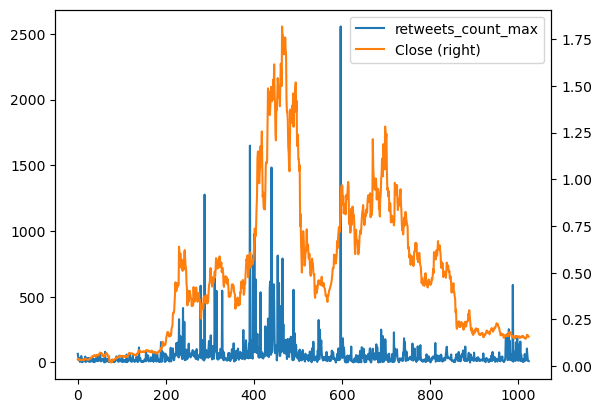

In [92]:
fig, ax = plt.subplots() 
prices_daily_tweets_df.plot(y=["retweets_count_max"], ax=ax)
prices_daily_tweets_df.plot(y=["Close"], ax=ax, secondary_y=True)

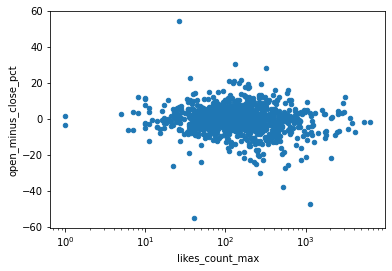

In [96]:
_ = prices_daily_tweets_df.plot(x="likes_count_max", y="open_minus_close_pct", kind="scatter")
plt.xscale("log")

In [64]:
# Here we create a sentiment index by subtracting the probability of negative from the probability of positive 
sentiment_df["positive_index"] =  sentiment_df["positive"] - sentiment_df["negative"]
sentiment_tweets_df = sentiment_df.merge(tweets_df, left_on="tweet_id", right_on="id")
sentiment_tweets_df["date_dt"] = pd.to_datetime(sentiment_tweets_df["date"])
# Here we create a weighted index by the likes associated with a tweet's sentiment
sentiment_tweets_df["retweets_pos_idx"] = sentiment_tweets_df["retweets_count"] * sentiment_tweets_df["positive_index"]
sentiment_tweets_df["likes_pos_idx"] = sentiment_tweets_df["likes_count"] * sentiment_tweets_df["positive_index"]

In [74]:
daily_sentiment_df = sentiment_tweets_df.groupby("date_dt")[["retweets_pos_idx", "retweets_count", "likes_count", "likes_pos_idx"]].sum()
daily_sentiment_df["retweets_weight_pos_idx"] = (daily_sentiment_df["retweets_pos_idx"] / daily_sentiment_df["retweets_count"])
daily_sentiment_df["likes_weight_pos_idx"] = (daily_sentiment_df["likes_pos_idx"] / daily_sentiment_df["likes_count"])
daily_sentiment_df["retweets_weight_pos_idx"].describe()

count    1020.000000
mean        0.435177
std         0.171334
min        -0.506775
25%         0.334481
50%         0.434606
75%         0.536277
max         0.941457
Name: retweets_weight_pos_idx, dtype: float64

In [80]:
# unfortunately, we find no correlation with the weighted sentiment scores and either the price or the 

tweets_prices_sentiment_df = tweets_prices_df.merge(daily_sentiment_df.reset_index(), on="date_dt")
tweets_prices_sentiment_df["open_minus_close_pct"] = (tweets_prices_sentiment_df["Open"] - tweets_prices_sentiment_df["Close"]) / tweets_prices_sentiment_df["Open"] * 100
tweets_prices_sentiment_df[["retweets_weight_pos_idx", "likes_weight_pos_idx", "Close", "open_minus_close_pct"]].corr()

,retweets_weight_pos_idx,likes_weight_pos_idx,Close,open_minus_close_pct
retweets_weight_pos_idx,1.000000,0.778327,-0.088601,0.031789
likes_weight_pos_idx,0.778327,1.000000,-0.146966,-0.047158
Close,-0.088601,-0.146966,1.000000,-0.079013
open_minus_close_pct,0.031789,-0.047158,-0.079013,1.000000


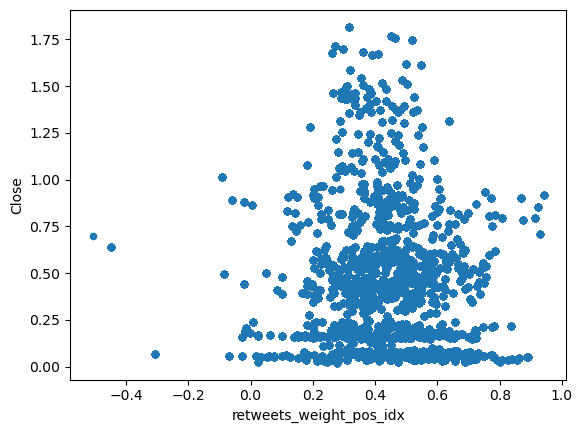

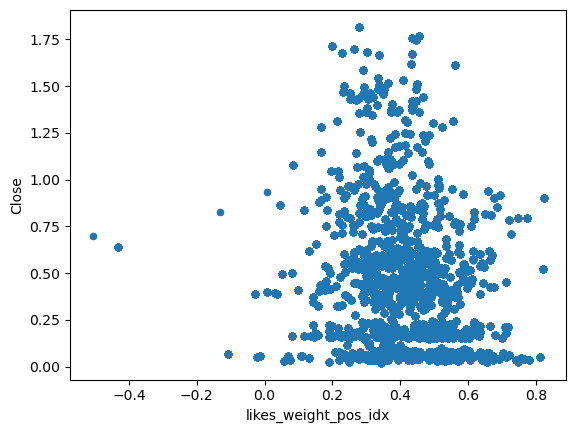

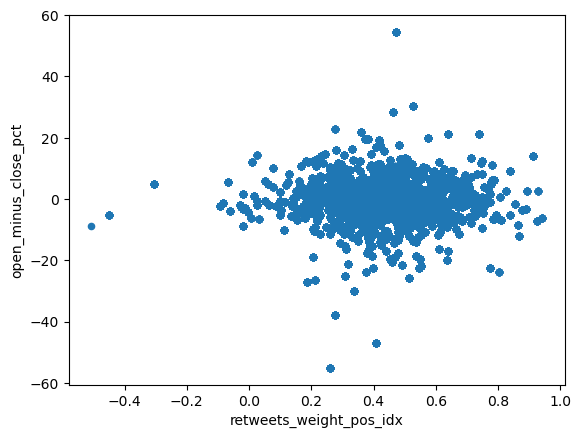

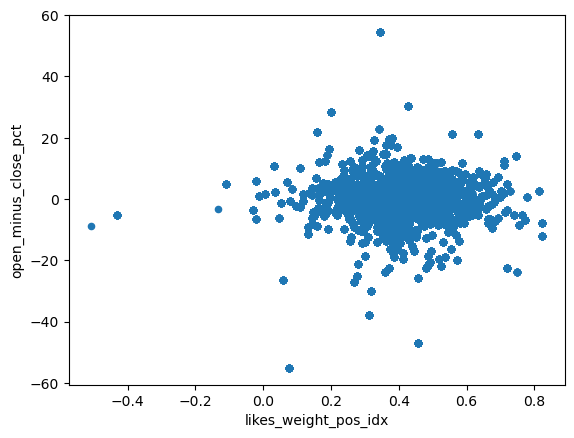

In [84]:
_ = tweets_prices_sentiment_df.plot(x="retweets_weight_pos_idx", y="Close", kind="scatter")
_ = tweets_prices_sentiment_df.plot(x="likes_weight_pos_idx", y="Close", kind="scatter")
_ = tweets_prices_sentiment_df.plot(x="retweets_weight_pos_idx", y="open_minus_close_pct", kind="scatter")
_ = tweets_prices_sentiment_df.plot(x="likes_weight_pos_idx", y="open_minus_close_pct", kind="scatter")

In [94]:
# here we plot the sentiment against the price over time and see that the sentiment is mostly noise, especially when there are fewre tweets

fig, ax = plt.subplots() 
tweets_prices_sentiment_df.plot(y=["retweets_weight_pos_idx"], ax=ax)
tweets_prices_sentiment_df.plot(y=["Close"], ax=ax, secondary_y=True)